# Bird Species Classification Project - Deep Learning

This notebook presents the step-by-step process of building a **multi-class image classification model** for bird species using deep learning techniques. We will cover data loading, preprocessing, model training, evaluation, and visualization on GPU for efficient computation.

We will utilize the following key components:

- **PyTorch**: For deep learning model implementation and training.
- **Torchvision**: For image transformations, datasets, and pretrained models.
- **Matplotlib/Seaborn**: For data visualization and analysis.
- **Grad-CAM**: For model explainability by visualizing class activation maps.

**Goal:**  
The primary goal is to develop a robust image classification pipeline that can accurately classify images of birds into 16 species. Additionally, we will perform **model interpretability analysis** to understand the decision-making process of the trained models.

**Dataset:**  
We use the **Bird Species Dataset** from Kaggle, which contains images of 16 different bird species across training, validation, and test sets. Each image is labeled with its species, and the dataset offers a balanced representation for each class.


In this cell, we will **import** all the essential libraries needed for the project. We import them here in one cell to keep the notebook clean and organized.


In [92]:
import os
import random
import numpy as np
import pandas as pd, json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import itertools
import torch.nn.functional as F
from copy import deepcopy
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [65]:
libs = {
    "numpy": "np",
    "pandas": "pd",
    "matplotlib": "plt",
    "seaborn": "sns",
    "torch": "torch",
    "torchvision": "torchvision",
    "sklearn": "sklearn",
    "PIL": "PIL",
}

for lib, alias in libs.items():
    try:
        mod = __import__(lib)
        version = getattr(mod, "__version__", "version attr not found")
        print(f"{lib:<12} version: {version}")
    except ImportError as e:
        print(f"{lib:<12} could NOT be imported. Please install it. Error: {e}")
        raise

print("\nAll libraries imported successfully if no error messages above.")

numpy        version: 1.26.4
pandas       version: 2.2.3
matplotlib   version: 3.7.2
seaborn      version: 0.12.2
torch        version: 2.6.0+cu124
torchvision  version: 0.21.0+cu124
sklearn      version: 1.2.2
PIL          version: 11.2.1

All libraries imported successfully if no error messages above.


# 1) Data Preprocessing

This section converts images into a consistent format, verifies labels/files, and prepares
train/validation/test splits. We also provide quick visualizations of the dataset and define
data augmentation (rotation, flip, zoom, color jitter) to improve generalization.


We specify the **dataset path** and set a global **random seed**. The dataset path points to the folder where all images are stored, so defining it once keeps the code organized and avoids repeated hardcoding. The random seed ensures deterministic behavior for operations like splitting the data into training, validation, and test sets. This **reproducibility** is crucial when comparing models or sharing the project with others.

In [66]:
DATASET_DIR = Path("/kaggle/input/bird-species-classification") 
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

SEED = 42
random.seed(SEED)

assert DATASET_DIR.exists(), f"Dataset path not found: {DATASET_DIR}"
[p.name for p in DATASET_DIR.iterdir()][:10]

['test_data', 'train_data']

This step rebuilds the dataset index so that labels correspond to actual species classes rather than split wrappers. Some datasets include nested split folders (e.g., train_data/…/species/…). We therefore define a list of split aliases such as train, train_data, valid, test and skip any folder whose name is an alias. For each image, we take the first non-alias directory below the split root as the **class label** and record the path–label–split triplet. Getting these definitions right is critical: if labels are wrong, every downstream analysis becomes misleading.

In [67]:
SPLIT_ALIASES = {
    "train": "train",
    "train_data": "train",
    "training": "train",
    "valid": "valid",
    "val": "valid",
    "validation": "valid",
    "test": "test",
    "test_data": "test",
}

try:
    IMG_EXTS
except NameError:
    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

def is_img(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def true_label_from(img_path: Path, split_root: Path):
    """Return the first non-alias directory component under split_root as the class label."""
    rel_parts = img_path.relative_to(split_root).parts  
    for part in rel_parts[:-1]:
        if part.lower() in SPLIT_ALIASES:   
            continue
        return part 
    return img_path.parent.name

rows = []
for top in DATASET_DIR.iterdir():
    if not top.is_dir():
        continue
    split_name = SPLIT_ALIASES.get(top.name.lower())
    if not split_name:
        continue

    for img in top.rglob("*"):
        if img.is_file() and is_img(img):
            label = true_label_from(img, top)
            rows.append((str(img), label, split_name))

df = pd.DataFrame(rows, columns=["path","label","split"]).reset_index(drop=True)
print(df.head())
print("\nCounts by split:\n", df["split"].value_counts(dropna=False))
print("\nUnique labels:", len(df["label"].unique()))
print("Some labels:", sorted(df['label'].unique())[:16])

                                                path   label split
0  /kaggle/input/bird-species-classification/test...  brhkyt  test
1  /kaggle/input/bird-species-classification/test...  brhkyt  test
2  /kaggle/input/bird-species-classification/test...  brhkyt  test
3  /kaggle/input/bird-species-classification/test...  brhkyt  test
4  /kaggle/input/bird-species-classification/test...  brhkyt  test

Counts by split:
 split
test     157
train    150
Name: count, dtype: int64

Unique labels: 16
Some labels: ['blasti', 'bonegl', 'brhkyt', 'cbrtsh', 'cmnmyn', 'gretit', 'hilpig', 'himbul', 'himgri', 'hsparo', 'indvul', 'jglowl', 'lbicrw', 'mgprob', 'rebimg', 'wcrsrt']


test = 157, train = 150 — This reflects the **raw distribution** before adding a validation set.

Our dataset variant indeed has **16 species** (abbreviated names such as brhkyt, cbrtsh, himbul, …).

The head of df now shows species abbreviations under label and correct split names under split exactly what we want.

We perform a lightweight integrity check by attempting to open each image. Files that cannot be opened are considered corrupted and removed from the index. This avoids runtime failures in data loaders and ensures that training is not interrupted by unreadable files. Although this check is optional, catching issues early improves reliability and reproducibility.

In [68]:
def readable(p: str) -> bool:
    try:
        Image.open(p).verify()
        return True
    except Exception:
        return False

_before = len(df)
df = df[df["path"].apply(readable)].reset_index(drop=True)
print(f"Kept {len(df)} images; removed corrupted: {_before - len(df)}")

Kept 307 images; removed corrupted: 0


The dataset is **clean**; we can proceed without special handling for broken files.

We display a compact sample grid showing one image per species. This offers a fast, qualitative check that labels match the visual content and helps build intuition about intra-class variation (pose, background, lighting). Such a preview is especially helpful when designing augmentation policies.

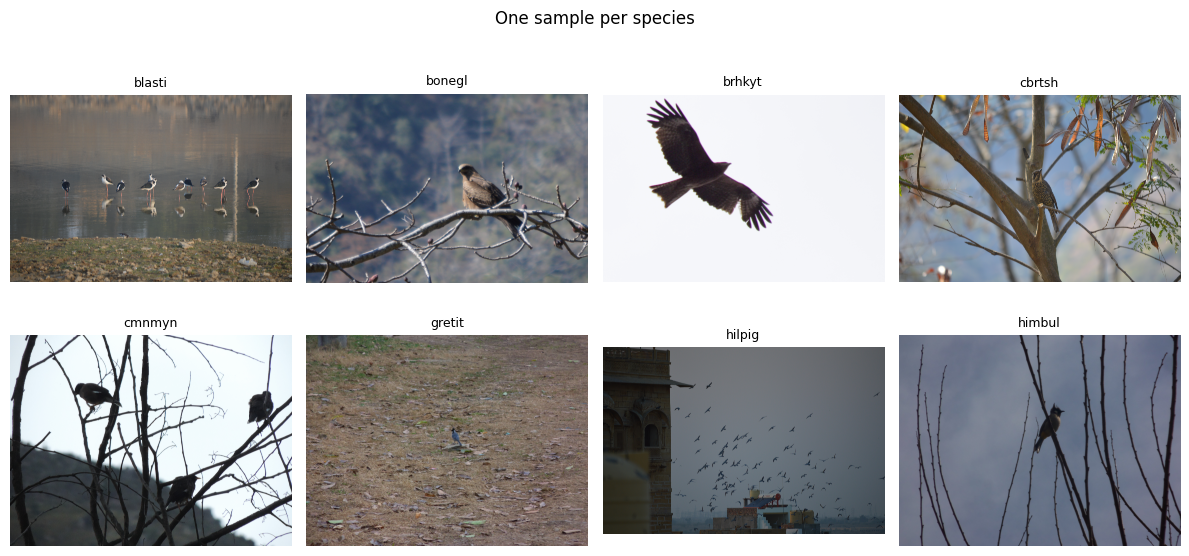

In [69]:
def pick_one(label, pref=("train","valid","test")):
    for sp in pref:
        s = df[(df["label"]==label) & (df["split"]==sp)]
        if len(s): return s.sample(1, random_state=SEED)["path"].iloc[0]

classes = sorted(df["label"].unique())[:8]
samples = [(c, pick_one(c)) for c in classes if pick_one(c) is not None]

cols=4; rows=math.ceil(len(samples)/cols)
plt.figure(figsize=(cols*3, rows*3))
for i,(cls,pth) in enumerate(samples,1):
    try:
        img = Image.open(pth).convert("RGB")
        plt.subplot(rows,cols,i); plt.imshow(img); plt.title(cls, fontsize=9); plt.axis("off")
    except: pass
plt.suptitle("One sample per species", y=0.98)
plt.tight_layout(); plt.show()

We partition the dataset into **70% train**, **15% validation**, and **15% test** using **stratified sampling**. Stratification preserves the class distribution across all splits, which yields more reliable validation metrics and a fair final evaluation on the test set. The split is controlled by a fixed random seed to ensure **reproducibility**.

In [70]:
train_idx, temp_idx = train_test_split(
    df.index,
    test_size=0.30,  
    random_state=SEED,
    stratify=df["label"]
)

valid_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,  
    random_state=SEED,
    stratify=df.loc[temp_idx, "label"]
)

df.loc[train_idx, "split"] = "train"
df.loc[valid_idx, "split"] = "valid"
df.loc[test_idx, "split"] = "test"

print("Final split counts:")
print(df["split"].value_counts())

Final split counts:
split
train    214
test      47
valid     46
Name: count, dtype: int64


After performing the **70/15/15 stratified split**, we plot the class distribution across train, validation, and test sets. This visualization helps ensure that each split contains a balanced representation of all classes, preserving the original class proportions. Maintaining balance across splits is crucial for reliable training, hyperparameter tuning, and final evaluation, as uneven class distributions can lead to biased performance metrics or model overfitting on dominant classes.

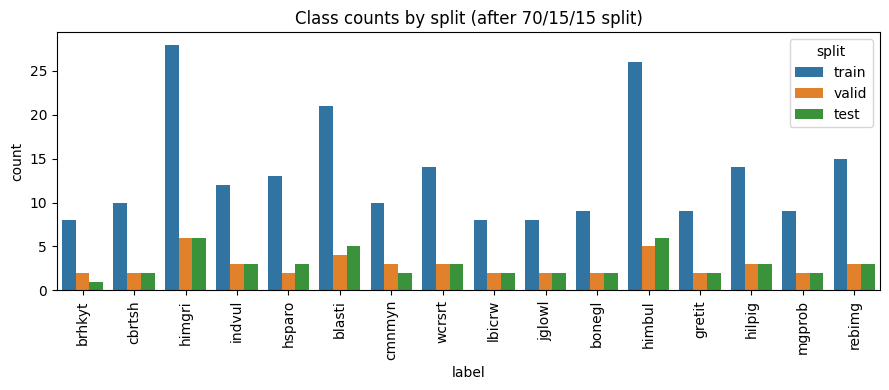

In [71]:
plt.figure(figsize=(9,4))
sns.countplot(data=df[df["split"].isin(["train","valid","test"])], 
              x="label", hue="split")
plt.xticks(rotation=90)
plt.title("Class counts by split (after 70/15/15 split)")
plt.tight_layout()
plt.show()

**Data augmentation** applies label-preserving transformations to training images to increase data diversity and reduce overfitting. For bird species, we want invariances that are realistic for photography—e.g., **horizontal flip (left/right)**, small **rotation**, mild **zoom**, and light **color jitter**—while avoiding aggressive edits that could distort morphology (e.g., heavy rotations or vertical flips that make perched birds look upside-down). 

We therefore use a moderate policy: resize to a common input size (224×224), apply RandomHorizontalFlip, a small RandomRotation (±12°), a gentle RandomResizedCrop (simulate zoom/framing), and light ColorJitter. Validation and test sets use deterministic transforms (resize → tensor → normalize) to reflect real, unseen data. We normalize with **ImageNet mean/std**, which is standard for transfer learning backbones.

We keep rotation small (±12°) because large angles can distort posture cues that are discriminative across species. We apply **horizontal flips** but not vertical flips; flipping up/down is rarely realistic for bird photos and can confuse the model. RandomResizedCrop with a high scale range (0.9–1.0) simulates mild **zoom/reframing** without over-cropping key traits (beak, wing patterns). **ColorJitter** is light so plumage colors remain faithful. RandomErasing is optional and kept very conservative; it can help robustness to small occlusions but should not be strong on small datasets.

In [72]:
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),             
    T.RandomHorizontalFlip(p=0.5),              # realistic left/right invariance
    T.RandomRotation(degrees=12),               # small rotations only
    T.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),  # mild zoom/crop
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # light color changes
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    # Optional: very light occlusion; comment out if you prefer not to use it
    # T.RandomErasing(p=0.1, scale=(0.02, 0.08), ratio=(0.3, 3.3))
])

eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_tfms, eval_tfms

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-12.0, 12.0], interpolation=nearest, expand=False, fill=0)
     RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=None)
     ToTensor()
     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
 ))

# 2) Model Training (CNN)

We turn the indexed table **df** into PyTorch **datasets** and **dataloaders**. Each split (train/valid/test) reads image paths, converts labels to integers, and applies the appropriate transform pipeline (stronger for train, deterministic for eval). Dataloaders batch examples efficiently and shuffle only the training set. This separation keeps preprocessing reproducible and training fast on GPU.

**Batc size**
**num workers**

In [73]:
classes = sorted(df["label"].unique().tolist())
label_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_label = {i: c for c, i in label_to_idx.items()}
num_classes = len(classes)

class BirdDfDataset(Dataset):
    def __init__(self, df, split, transform=None, label_to_idx=None):
        self.df = df[df["split"]==split].reset_index(drop=True)
        self.paths = self.df["path"].tolist()
        self.targets = [label_to_idx[y] for y in self.df["label"]]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.targets[i]

train_ds = BirdDfDataset(df, "train", transform=train_tfms, label_to_idx=label_to_idx)
valid_ds = BirdDfDataset(df, "valid", transform=eval_tfms,  label_to_idx=label_to_idx)
test_ds  = BirdDfDataset(df, "test",  transform=eval_tfms,  label_to_idx=label_to_idx)

BATCH_SIZE = 32
NUM_WORKERS = 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

len(train_ds), len(valid_ds), len(test_ds), num_classes

(214, 46, 47, 16)



In this CNN architecture, we first use **Convolutional** and **Pooling Layers** to extract hierarchical features from the bird images. The **Dropout Layer** helps prevent overfitting by making the network more robust, while **Dense Layers** combine the extracted features to produce the final predictions. Finally, **Activation Functions** ensure the model can capture complex patterns and provide class probabilities. Together, these layers form the backbone of the network, enabling it to learn meaningful representations for accurate bird species classification.


---

- **Convolutional Layers (Conv2D):**  
  These layers learn **local patterns** such as edges, textures, or shapes by sliding small learnable filters (kernels) across the image. Stacking multiple convolutional layers helps the model detect more **complex features** at deeper levels.

- **Pooling Layers (MaxPool):**  
  Used to **reduce spatial dimensions** while keeping the most important information. Max pooling, for example, keeps the strongest activation in each small region, introducing **translation invariance** and lowering computation.

- **Dropout:**  
  A **regularization technique** that randomly deactivates some neurons during training, forcing the network to rely on multiple paths and thus reducing **overfitting**.

- **Dense (Fully Connected) Layers:**  
  After flattening the learned features, these layers combine all information to make the **final decision** about class probabilities.

- **Activation Functions (ReLU):**  
  **ReLU** introduces non-linearity, enabling the network to learn complex relationships.



We build a compact 3-block CNN: each block is **Conv** → **BatchNorm** → **ReLU** → **MaxPool**, progressively increasing channels (32→64→128) and reducing spatial size. We then apply **AdaptiveAvgPool2d(1)** to aggregate spatial information into a single vector per channel, followed by **Dropout** and a **Dense** layer that outputs num_classes logits. This keeps the model lightweight and regularized, suitable for a modest dataset, while still capturing useful hierarchical features.


In [94]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_p=0.3):
        super().__init__()
        def conv_block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            conv_block(3, 32),   # 224 -> 112
            conv_block(32, 64),  # 112 -> 56
            conv_block(64, 128)  # 56  -> 28
        )
        self.pool = nn.AdaptiveAvgPool2d(1)   # 128 x 1 x 1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=num_classes).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}") 

Total parameters: 95536


- **EPOCHS (Number of training iterations):**  
  The total number of times the model will see the entire training dataset. More epochs give the model more opportunities to learn, but too many can lead to **overfitting**.

- **LR (Learning Rate):**  
  Controls the step size for weight updates during optimization. A **smaller value** leads to slower but more stable convergence, while a **larger value** speeds up training but may overshoot the optimum.

- **Adam Optimizer:**  
  An adaptive learning rate optimization algorithm that combines the advantages of **AdaGrad** (adaptive learning rates) and **RMSProp** (momentum-like updates). It typically works well out-of-the-box for many deep learning tasks.


  In this configuration, the model trains for up to **50 epochs** with a **learning rate** of 0.001. We monitor the **validation accuracy** at each epoch, and if it does not improve for **5 consecutive epochs**, training stops early, keeping the best model weights saved to `"best_cnn.pt"`. The **Adam optimizer** efficiently adjusts learning rates for each parameter, often leading to faster and more reliable convergence compared to standard stochastic gradient descent.

In [75]:
EPOCHS = 60
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

best_acc = 0.0
best_path = "best_cnn.pt"

Each epoch alternates between training and validation. We accumulate loss and correct predictions to compute accuracy. If validation accuracy improves, we save the checkpoint and reset patience; otherwise, we decrement patience and stop early when it reaches zero. This balances training time and generalization.

During training the resource panel showed **high CPU usage** and **0% GPU**, suggesting that either the model and/or the batches were not on the GPU. When tensors or the model stay on CPU, PyTorch silently does the work on CPU even if a GPU is available. This cell is a quick sanity check to verify that CUDA is available and that we are actually moving both the model parameters and a sample batch to the GPU.

In [76]:
assert torch.cuda.is_available(), "CUDA not available. Turn on GPU in Kaggle settings."
print("Device count:", torch.cuda.device_count())
print("Using:", torch.cuda.get_device_name(0))

device = torch.device("cuda:0")

model = model.to(device)

xb, yb = next(iter(train_loader))
print("xb device before:", xb.device)  
xb = xb.to(device, non_blocking=True)
yb = torch.tensor(yb, device=device)
print("xb device after:", xb.device)   
print("model first param device:", next(model.parameters()).device)

Device count: 2
Using: Tesla T4
xb device before: cpu
xb device after: cuda:0
model first param device: cuda:0


We can interpret the output as follows:
- `Device count: 2` and `Using: Tesla T4` → The environment exposes two GPUs; CUDA is **available**.  
- `xb device before: cpu` → Batches are created on CPU by default (normal for DataLoader).  
- `xb device after: cuda:0` → The batch is **successfully moved** to the GPU for computation.  
- `model first param device: cuda:0` → The model’s weights are **on the GPU** as well.

This code defines and executes the **training loop** for our CNN model on the bird species dataset.

In [77]:
train_losses, valid_losses = [], []
train_accs,   valid_accs   = [], []

In [78]:
torch.backends.cudnn.benchmark = (device.type == "cuda")

def run_epoch(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total, correct, total_loss = 0, 0, 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = torch.as_tensor(yb, device=device)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(xb)
                loss = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return total_loss/total, correct/total

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, model, optimizer)
    va_loss, va_acc = run_epoch(valid_loader, model, optimizer=None)

    train_losses.append(tr_loss);  valid_losses.append(va_loss)
    train_accs.append(tr_acc);     valid_accs.append(va_acc)

    improved = va_acc > best_acc
    if improved:
        best_acc = va_acc
        torch.save(model.state_dict(), best_path)

    msg = "✓ saved" if improved else f"best {best_acc:.3f}"
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"valid loss {va_loss:.4f} acc {va_acc:.3f} | {msg}")

Epoch 01 | train loss 2.6952 acc 0.145 | valid loss 2.5965 acc 0.174 | ✓ saved
Epoch 02 | train loss 2.3457 acc 0.336 | valid loss 2.3916 acc 0.261 | ✓ saved
Epoch 03 | train loss 2.1908 acc 0.355 | valid loss 2.2607 acc 0.239 | best 0.261
Epoch 04 | train loss 2.0736 acc 0.379 | valid loss 2.1489 acc 0.283 | ✓ saved
Epoch 05 | train loss 2.0447 acc 0.383 | valid loss 2.0079 acc 0.304 | ✓ saved
Epoch 06 | train loss 2.0054 acc 0.374 | valid loss 1.9341 acc 0.326 | ✓ saved
Epoch 07 | train loss 1.9641 acc 0.374 | valid loss 1.8489 acc 0.435 | ✓ saved
Epoch 08 | train loss 1.8982 acc 0.397 | valid loss 1.7573 acc 0.435 | best 0.435
Epoch 09 | train loss 1.8865 acc 0.411 | valid loss 1.7571 acc 0.435 | best 0.435
Epoch 10 | train loss 1.8434 acc 0.421 | valid loss 1.7589 acc 0.478 | ✓ saved
Epoch 11 | train loss 1.8210 acc 0.449 | valid loss 1.6677 acc 0.543 | ✓ saved
Epoch 12 | train loss 1.7634 acc 0.477 | valid loss 1.7042 acc 0.457 | best 0.543
Epoch 13 | train loss 1.7795 acc 0.467 |

Summarizes the **training** and **validation performance** of our CNN model over 50 epochs. Each row shows:

- **Epoch Number:** Indicates the current epoch of training.
- **Train Loss & Accuracy:** Average loss and classification accuracy on the training set.
- **Valid Loss & Accuracy:** Metrics on the validation set (used for performance monitoring).
- **"✓ saved"** → The model achieved a **new best validation **accuracy** and was saved as the current best checkpoint.
- **"best {value}"** → Shows the best validation accuracy reached so far.

---

**Best Model:**  
- **Epoch 52** achieved the **highest validation accuracy** of **71.7%** with a validation loss of **1.1338**, showing significant improvement from initial epochs.

---

The CNN model shows **consistent training progress** with no overfitting observed:
- **Training loss** decreased smoothly across epochs.

In [79]:
history = pd.DataFrame({
    "epoch": list(range(1, len(train_losses)+1)),
    "train_loss": train_losses,
    "valid_loss": valid_losses,
    "train_acc":  train_accs,
    "valid_acc":  valid_accs,
})
history.to_csv("history.csv", index=False)

with open("history.json","w") as f:
    json.dump(history.to_dict(orient="list"), f)

# 3) Model Evaluation

After training the model, we need a comprehensive evaluation to understand both its performance metrics and decision-making behavior. This stage goes beyond just reporting accuracy; it helps us identify strengths, weaknesses, and areas for improvement. We divide the evaluation process into three key components:


#### 1. Accuracy and Loss Curves
By plotting accuracy and loss against epochs for both the training and validation sets, we can diagnose training behavior:

- **Consistent improvement** in training and validation accuracy usually indicates good learning progress.  
- **Divergence** between training and validation curves often signals overfitting, while **flat curves** may indicate underfitting or poor learning rates.  
- These plots help in deciding whether **data augmentation**, **regularization techniques**, or **hyperparameter tuning** are needed.

---

#### 2. Confusion Matrix & Classification Report
Accuracy alone may be misleading, especially in imbalanced datasets:

- A **confusion matrix** shows class-wise predictions, making it easy to see which bird species are frequently misclassified.  
- The **classification report** provides **accuracy, precision, recall, and F1-score** for each class.  

Key insights:  
- **Low recall** → the model misses many true examples of a class.  
- **Low precision** → the model produces many false positives.

---

#### 3. Grad-CAM Heatmaps 
Performance metrics tell us **how well** the model works, but not **why**.

- Using **Grad-CAM (Gradient-weighted Class Activation Mapping)**, we visualize the important regions of input images that influence the model’s decisions.  
- Ideally, the heatmap should focus on the **bird itself** (e.g., wings, head, unique features), not the background.  

If attention drifts to irrelevant areas (e.g., branches, sky), it indicates a need for **better data preprocessing** or **training strategies**.




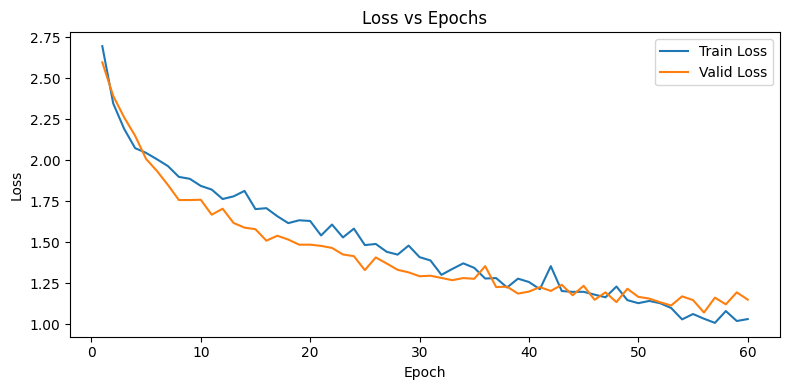

In [80]:
hist = pd.read_csv("history.csv")
epochs = hist["epoch"]

plt.figure(figsize=(8,4))
plt.plot(epochs, hist["train_loss"], label="Train Loss")
plt.plot(epochs, hist["valid_loss"], label="Valid Loss")
plt.legend(); plt.title("Loss vs Epochs"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.tight_layout(); plt.show()

In this case, both training and validation losses steadily decrease, showing that the **model is learning well** and does not exhibit significant **overfitting**. The final loss values being close suggests a good generalization capability on unseen data.

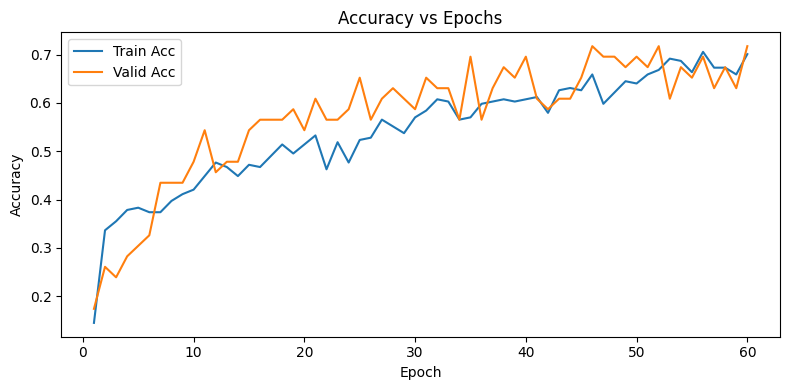

In [81]:
hist = pd.read_csv("history.csv")
epochs = hist["epoch"]

plt.figure(figsize=(8,4))
plt.plot(epochs, hist["train_acc"], label="Train Acc")
plt.plot(epochs, hist["valid_acc"], label="Valid Acc")
plt.legend(); plt.title("Accuracy vs Epochs"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.tight_layout(); plt.show()

Both curves rise consistently, with validation accuracy closely following training accuracy. The absence of large gaps indicates **no overfitting**, and the steady growth confirms the model’s learning stability throughout the training process.

The **Confusion Matrix** is a table that shows the number of correct and incorrect predictions for each class.  
- Rows represent the **true labels**.
- Columns represent the **predicted labels**.  

A perfect classifier would have all values on the diagonal (correct predictions) and zeros elsewhere.

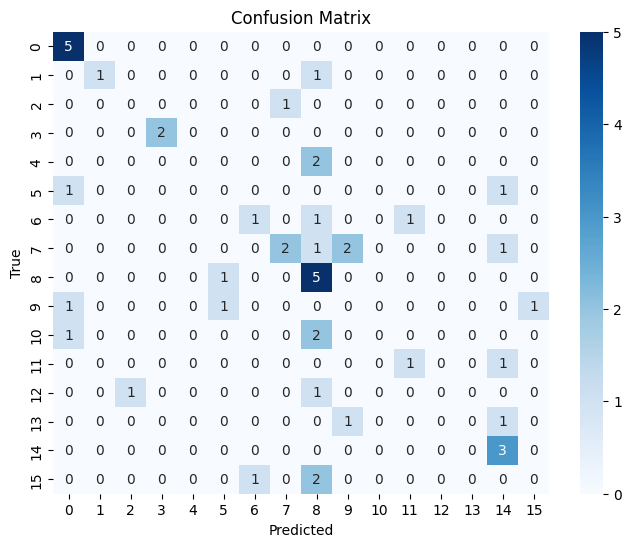

In [83]:
class_names = sorted(set(all_labels))  


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The **Classification Report** summarizes model performance per class and as global aggregates. It is especially helpful when classes are imbalanced or some classes are systematically confused.

- **Precision**  
  Of the samples the model **predicted as this class**, how many were actually correct. *High precision* means the model rarely raises **false alarms** for that class.

- **Recall**  
  Of the samples that **belong to this class**, how many the model successfully found. *High recall* means the model rarely **misses** true instances of that class.

- **F1-Score**  
  A single score that balances **precision** and **recall**. Useful when you need a single number that rewards models that both *find* most true cases (recall) and *avoid* false alarms (precision).

- **Accuracy**  
  Fraction of **all predictions** that were correct across every class. Easy to read, but can be **misleading** when the dataset is imbalanced.

- **Macro Average**  
  Simple average over classes, **treating each class equally** regardless of how many samples it has. Good to judge performance on **rare classes**, but can understate performance when many samples belong to a few classes.

- **Weighted Average**  
  Average over classes **weighted by support** (class frequency). Reflects overall performance on the dataset as it is distributed; robust when classes are imbalanced.


In [86]:
class_names = [str(c) for c in sorted(set(all_labels))]

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.50      0.33      0.40         3
           7       0.67      0.33      0.44         6
           8       0.33      0.83      0.48         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         3
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.43      1.00      0.60         3
          15       0.00      0.00      0.00         3

    accuracy                           0.43        47
  

For image classification models, we want to *show which regions of the test images the model relied on* when making a prediction. We use **Grad-CAM** (Gradient-weighted Class Activation Mapping) to produce a heatmap for a target class.

We tap into the **last convolutional layer**, run a forward pass, and then backprop the score of a target class to get gradients. We weight the layer’s feature maps by the average gradients, sum them, apply ReLU, and upsample to input size. The resulting heatmap highlights the most influential regions.




In [88]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def denorm(x):
    """Undo normalization for visualization. x: [B,C,H,W] on device."""
    mean = torch.tensor(IMAGENET_MEAN, device=x.device)[None, :, None, None]
    std  = torch.tensor(IMAGENET_STD,  device=x.device)[None, :, None, None]
    return (x * std + mean).clamp(0, 1)

class GradCAM:
    """Framework-agnostic Grad-CAM for the last conv layer."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        # forward & backward hooks
        self.h_fwd = target_layer.register_forward_hook(self._save_activation)
        self.h_bwd = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def remove(self):
        self.h_fwd.remove(); self.h_bwd.remove()

    @torch.no_grad()
    def _upsample(self, cam, size):
        return F.interpolate(cam, size=size, mode='bilinear', align_corners=False)

    def __call__(self, x, class_idx=None):
        """
        x: input tensor [B,3,H,W] on device
        class_idx: [B] LongTensor of target classes; if None uses argmax
        returns: Grad-CAM maps in [B,H,W], normalized to [0,1]
        """
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)                     # [B,num_classes]
        if class_idx is None:
            class_idx = logits.argmax(1)
        scores = logits.gather(1, class_idx.view(-1,1)).sum()
        scores.backward()                          

        A   = self.activations                    # [B,K,h,w]
        dA  = self.gradients                      # [B,K,h,w]
        w   = dA.mean(dim=(2,3), keepdim=True)    # [B,K,1,1]
        cam = (w * A).sum(dim=1, keepdim=True)    # [B,1,h,w]
        cam = F.relu(cam)
        cam = self._upsample(cam, x.shape[2:])    # [B,1,H,W]
        cam = cam.squeeze(1)                      # [B,H,W]

        # normalize to [0,1] per image
        cam_min = cam.amin(dim=(1,2), keepdim=True)
        cam_max = cam.amax(dim=(1,2), keepdim=True)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        return cam


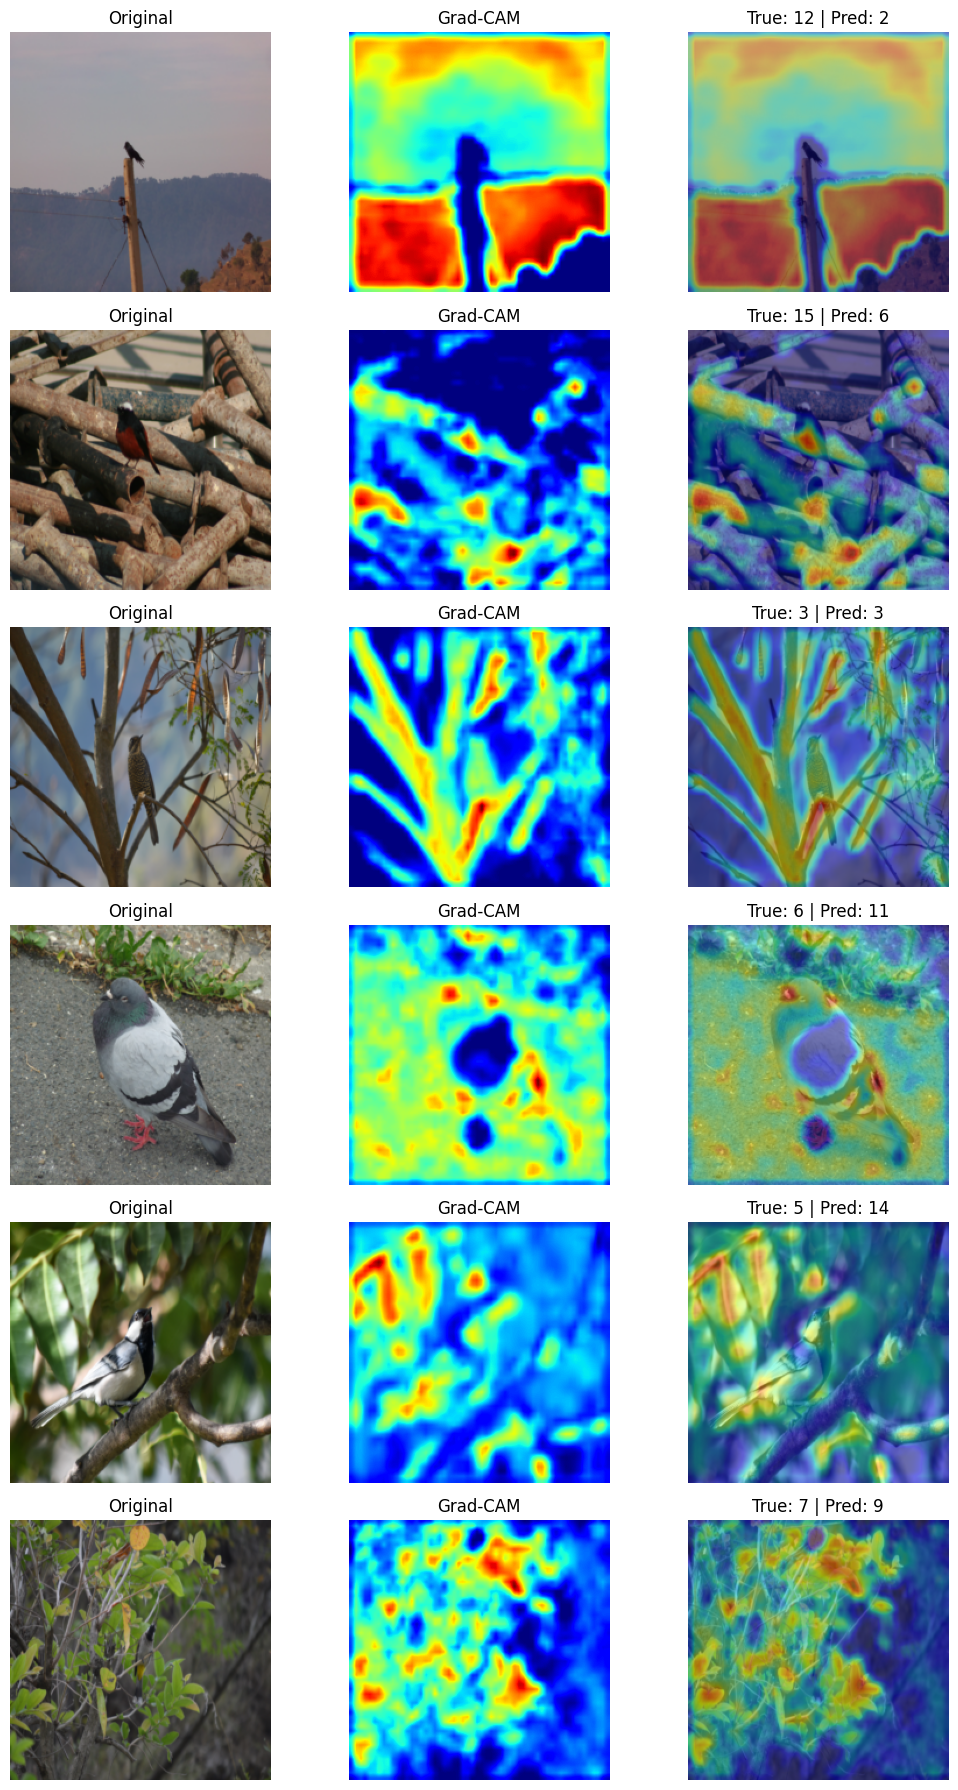

In [89]:
target_layer = model.features[-1][0]  

cam = GradCAM(model, target_layer)
model.eval()


try:
    label_names = class_names
except NameError:
    label_names = [str(c) for c in sorted(set(getattr(test_ds, 'targets', [])))] \
                  if hasattr(test_ds, 'targets') else None

# sample a few test images
k = 6
indices = random.sample(range(len(test_ds)), k=min(k, len(test_ds)))

imgs, y_true = [], []
for i in indices:
    img, y = test_ds[i]            
    imgs.append(img)
    y_true.append(int(y))

xb = torch.stack(imgs).to(device)
with torch.no_grad():
    logits = model(xb)
y_pred = logits.argmax(1).cpu().tolist()

# compute Grad-CAM using the predicted class for each image
cams = cam(xb, class_idx=torch.tensor(y_pred, device=xb.device))
cam.remove()  

# plot: original, heatmap, overlay
def overlay_heatmap(rgb, heat, alpha=0.4, cmap='jet'):
    cmap_fn = plt.get_cmap(cmap)
    heat_rgb = cmap_fn(heat)[..., :3]             # HxWx3 in [0,1]
    return np.clip((1-alpha)*rgb + alpha*heat_rgb, 0, 1)

xb_den = denorm(xb).cpu()                         

cols = 3
rows = len(y_true)
plt.figure(figsize=(cols*3.6, rows*3.0))
for i in range(rows):
    orig  = xb_den[i].permute(1,2,0).numpy()
    heat  = cams[i].cpu().numpy()
    over  = overlay_heatmap(orig, heat, alpha=0.45)

    true_name = label_names[y_true[i]] if label_names else str(y_true[i])
    pred_name = label_names[y_pred[i]] if label_names else str(y_pred[i])
    title = f"True: {true_name} | Pred: {pred_name}"

    # original
    ax = plt.subplot(rows, cols, i*cols+1); ax.imshow(orig); ax.set_axis_off(); ax.set_title("Original")
    # heatmap
    ax = plt.subplot(rows, cols, i*cols+2); ax.imshow(heat, cmap='jet'); ax.set_axis_off(); ax.set_title("Grad-CAM")
    # overlay
    ax = plt.subplot(rows, cols, i*cols+3); ax.imshow(over); ax.set_axis_off(); ax.set_title(title)

plt.tight_layout(); plt.show()


- **Left Column (Original):** The original test images from the dataset.

- **Middle Column (Grad-CAM):** Heatmaps showing the areas the CNN focused on while making predictions. Warmer colors (red/yellow) indicate high attention regions, while cooler colors (blue) indicate less attention.

- **Right Column (Overlay):** Grad-CAM heatmaps overlaid on the original images for better interpretability.

Each row also shows the **true label** vs **predicted label**, allowing us to visually analyze why the model was correct or wrong.
For instance:

- If the highlighted areas focus correctly on the bird but the prediction is wrong, this may indicate **model confusion between similar species**.

- If attention spreads outside the object of interest, it may suggest **noise in feature extraction** or **insufficient training**.

Overall, Grad-CAM provides an intuitive explanation for CNN decisions, helping diagnose model strengths and weaknesses beyond raw accuracy metrics.

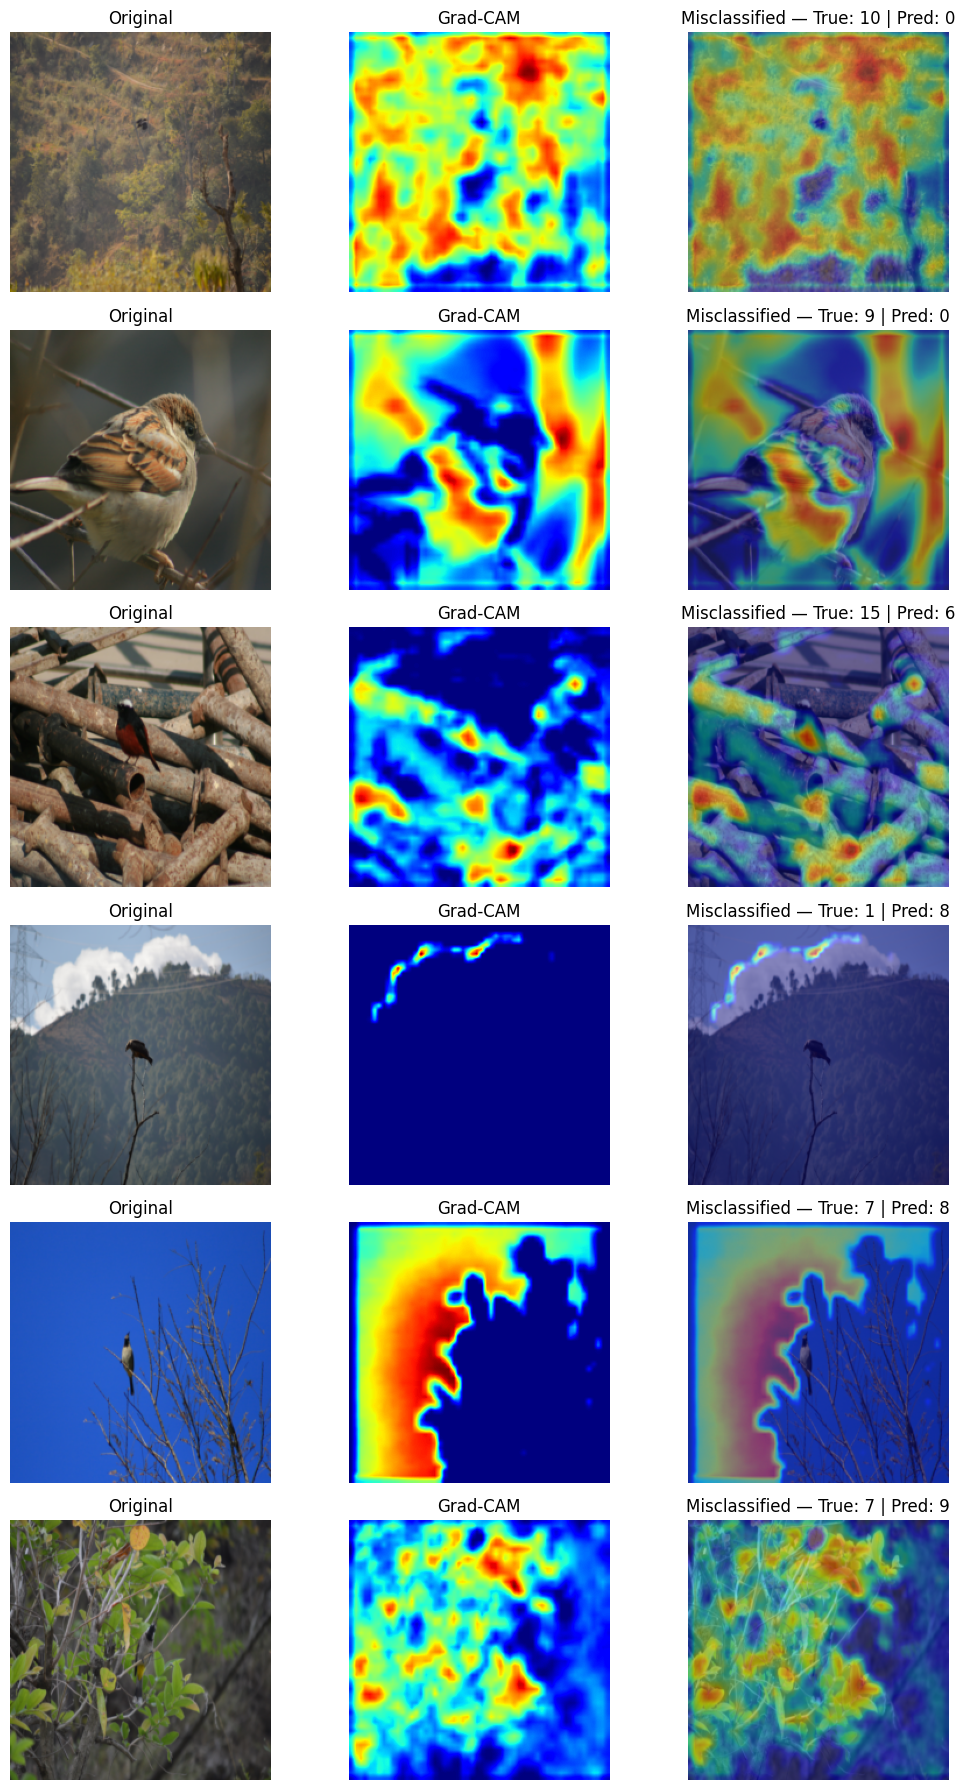

In [91]:
# gather a small batch of misclassified samples for diagnostic Grad-CAMs
mis_idx = []
model.eval()
with torch.no_grad():
    for i in range(len(test_ds)):
        img, y = test_ds[i]
        xb = img.unsqueeze(0).to(device)
        pred = model(xb).argmax(1).item()
        if pred != int(y):
            mis_idx.append((i, int(y), pred))
        if len(mis_idx) >= 6: 
            break

if mis_idx:
    imgs, y_true, y_pred = [], [], []
    for i, yt, yp in mis_idx:
        img, _ = test_ds[i]
        imgs.append(img); y_true.append(yt); y_pred.append(yp)

    xb = torch.stack(imgs).to(device)
    cams = GradCAM(model, target_layer)(xb, class_idx=torch.tensor(y_pred, device=xb.device))

    xb_den = denorm(xb).cpu()
    rows, cols = len(imgs), 3
    plt.figure(figsize=(cols*3.6, rows*3.0))
    for i in range(rows):
        orig = xb_den[i].permute(1,2,0).numpy()
        heat = cams[i].cpu().numpy()
        over = overlay_heatmap(orig, heat, alpha=0.45)

        tn = label_names[y_true[i]] if label_names else str(y_true[i])
        pn = label_names[y_pred[i]] if label_names else str(y_pred[i])
        title = f"Misclassified — True: {tn} | Pred: {pn}"

        ax = plt.subplot(rows, cols, i*cols+1); ax.imshow(orig); ax.set_axis_off(); ax.set_title("Original")
        ax = plt.subplot(rows, cols, i*cols+2); ax.imshow(heat, cmap='jet'); ax.set_axis_off(); ax.set_title("Grad-CAM")
        ax = plt.subplot(rows, cols, i*cols+3); ax.imshow(over); ax.set_axis_off(); ax.set_title(title)

    plt.tight_layout(); plt.show()
else:
    print("No misclassified samples found in the first pass.")


This visualization uses **Grad-CAM** to highlight the regions that the model focused on when making predictions for **misclassified test images**.  

- **Red and yellow areas** represent the most influential regions for the model's decision.  
- **Blue regions** indicate areas with less influence on the classification decision.  
- Many misclassified cases show the model focusing on **irrelevant background regions** instead of the bird itself, which likely caused the wrong predictions.  
- Some images show **occlusion** or **low contrast**, making it difficult for the model to identify distinctive bird features.  


The model may require **better data preprocessing** or **data augmentation** to handle variability in image quality and backgrounds. Balancing the dataset or using **attention mechanisms** might help the model focus on the correct object regions.  

Overall, this analysis helps identify **why the model failed on specific samples**, guiding potential improvements in both data quality and model architecture.


# 4) Hyperparameter Optimization

Hyperparameter optimization is the process of systematically searching for the best set of hyperparameters that maximize model performance. Unlike model parameters, which are learned during training, hyperparameters control the learning process itself (e.g., learning rate, dropout rate, batch size) and must be set before training begins.  

The goal of this step is to experiment with different hyperparameter combinations and select the configuration that yields the highest validation accuracy, ensuring better model generalization.


For this project, we chose **three hyperparameters** to optimize, considering both impact on performance and computational efficiency:

1. **Learning Rate (LR)**  
   - Controls how much the model weights are updated after each batch.
   - Too high → risk of divergence; too low → slow convergence.  
   - **Values tested:** `[1e-4, 3e-4, 1e-3, 3e-3]`

2. **Dropout Rate**  
   - Randomly deactivates a fraction of neurons during training to prevent overfitting.  
   - **Values tested:** `[0.0, 0.2, 0.3, 0.4]`

3. **Batch Size**  
   - Number of samples processed before updating the model parameters.  
   - Affects training speed and stability.  
   - **Values tested:** `[16, 32, 64]`

---

### Optimization Procedure  

- We **sample random combinations** of the above hyperparameters (Random Search).  
- For each combination:  
  1. Train the model for **6 epochs** on the training set.  
  2. Evaluate on the validation set to measure accuracy.  
  3. Record the best accuracy and the epoch where it occurred.  

Finally, we **sort all trials** by validation accuracy and select the configuration with the **highest accuracy** as the best hyperparameter set.


In [95]:
SEED = 42
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)

LR_SPACE       = [1e-4, 3e-4, 1e-3, 3e-3]
DROPOUT_SPACE  = [0.0, 0.2, 0.3, 0.4]
BATCH_SPACE    = [16, 32, 64]

def sample_trials(n=12):
    combos = list(itertools.product(LR_SPACE, DROPOUT_SPACE, BATCH_SPACE))
    random.shuffle(combos)
    return combos[:n]

def make_loaders(batch_size):
    pin = (device.type == "cuda")
    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=pin
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_ds, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=pin
    )
    return train_loader, valid_loader

def train_for_epochs(model, train_loader, valid_loader, lr, epochs=6):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_va, best_epoch = 0.0, 0

    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(xb), yb)
            loss.backward(); optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device)
                preds = model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total   += yb.size(0)
        va_acc = correct / max(1,total)
        if va_acc > best_va:
            best_va, best_epoch = va_acc, ep
        print(f"  ep {ep:02d} | valid acc {va_acc:.3f}")
    return best_va, best_epoch

trials = sample_trials(n=12)
results = []

for i, (lr, dp, bs) in enumerate(trials, 1):
    print(f"\nTrial {i:02d} — lr={lr}, dropout={dp}, batch={bs}")
    m = CNN(num_classes=num_classes, dropout_p=dp)
    tr_loader, va_loader = make_loaders(batch_size=bs)
    best_va, best_ep = train_for_epochs(m, tr_loader, va_loader, lr=lr, epochs=6)
    results.append({"lr": lr, "dropout": dp, "batch": bs, "val_acc": best_va, "best_ep": best_ep})

results = sorted(results, key=lambda r: r["val_acc"], reverse=True)
print("\nTop trials:")
for r in results[:5]:
    print(r)
best_cfg = results[0]
print("\nBest config:", best_cfg)


Trial 01 — lr=0.001, dropout=0.2, batch=64
  ep 01 | valid acc 0.196
  ep 02 | valid acc 0.304
  ep 03 | valid acc 0.261
  ep 04 | valid acc 0.239
  ep 05 | valid acc 0.283
  ep 06 | valid acc 0.304

Trial 02 — lr=0.0003, dropout=0.4, batch=64
  ep 01 | valid acc 0.130
  ep 02 | valid acc 0.196
  ep 03 | valid acc 0.261
  ep 04 | valid acc 0.283
  ep 05 | valid acc 0.304
  ep 06 | valid acc 0.326

Trial 03 — lr=0.001, dropout=0.0, batch=16
  ep 01 | valid acc 0.261
  ep 02 | valid acc 0.283
  ep 03 | valid acc 0.304
  ep 04 | valid acc 0.304
  ep 05 | valid acc 0.370
  ep 06 | valid acc 0.435

Trial 04 — lr=0.0001, dropout=0.4, batch=32
  ep 01 | valid acc 0.087
  ep 02 | valid acc 0.087
  ep 03 | valid acc 0.130
  ep 04 | valid acc 0.283
  ep 05 | valid acc 0.304
  ep 06 | valid acc 0.370

Trial 05 — lr=0.0003, dropout=0.4, batch=16
  ep 01 | valid acc 0.326
  ep 02 | valid acc 0.413
  ep 03 | valid acc 0.413
  ep 04 | valid acc 0.391
  ep 05 | valid acc 0.391
  ep 06 | valid acc 0.3